#Amazon Ratings Prediction

Dataset: https://www.kaggle.com/datasets/lokeshparab/amazon-products-dataset

The amazaon products dataset is divided into 142 subcategories. Each subcategory is represented by a .csv file. We preprocessed 5 subcategories. The categories are: televisions, amazon fashion, Luxury Beauty

## Column Description
1. __name__ : The name of the product.
2. __main_category__ : The main category of the product belong.
3. __sub_category__ : The main category of the product belong.
4. __image__ : The image of the product look like.
5. __link__ : The amazon website reference link of the product.
6. __ratings__ : The ratings given by amazon customers of the product.
7. __no of ratings__ : The number of ratings given to this product in amazon shopping.
8. __discount_price__ : The discount prices of the product in rupees.
9. __actual_price__ : The actual MRP of the product in rupees.
###Later added
10. __actual_price_usd__ : The actual MRP of the product converted to US dollars at an exchange rate of 1 USD = 82.99 rupees.

11. __discount_price_usd:__ : The discounted price of the product converted to US dollars at an exchange rate of 1 USD = 82.99 rupees.

12. __discount_rate:__ : The percentage of discount applied to the product, calculated as ((actual_price_usd - discount_price_usd) / actual_price_usd) * 100.

12. __agg_rating__: The aggregate rating of the product, calculated by multiplying the ratings with the number of ratings.


## Scales
### Categorical and Textual Columns:
- name
- main_category
- sub_category
- image
- link

### Numerical Columns:
- no_of_ratings
- discount_price
- actual_price

In [ ]:
!git clone https://github.com/mickjeon/amazon_sales_prediction.git

Cloning into 'amazon_sales_prediction'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 47 (delta 8), reused 40 (delta 4), pack-reused 0
Receiving objects: 100% (47/47), 7.86 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

# Amazon Fashion

## Number of observation
The raw data consists of __2352__ observations. After excluding null values and data with random strings in the price field and ratings, the pre-processed data consists of a total of __1985__ observations.


In [ ]:
amz_fashion_raw_data = pd.read_csv("amazon_sales_prediction/dataset/Amazon Fashion.csv")
amz_fashion_raw_data.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,Aqualogica Glow+ Dewy Sunscreen SPF 50 PA+++ F...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51TSC6Uogx...,https://www.amazon.in/Aqualogica-Sunscreen-Pro...,4.2,"3,628",₹351,₹399
1,MARVIK Soft Silicone Adjustable Band Strap Com...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51vYDop04S...,https://www.amazon.in/MARVIK-Silicone-Adjustab...,3.9,291,₹249,₹999
2,108 Panchatantra Stories for Children (Illustr...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/81VJ+MAc7Y...,https://www.amazon.in/108-Panchatantra-Stories...,4.4,"2,950",₹125,₹160
3,Black and White and Blue: Adult Cinema From th...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51RIhaW3t1...,https://www.amazon.in/Black-White-Blue-Cinema-...,4.2,8,NaN,₹584.16
4,SAFARI 15 Ltrs Sea Blue Casual/School/College ...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/61kmCas5OC...,https://www.amazon.in/SAFARI-Ltrs-Casual-Backp...,4.0,"17,985",₹299,₹799


In [ ]:
amz_fashion_raw_data.describe()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
count,2352,2352,2352,2352,2352,2146,2146,2186,2341
unique,2185,1,1,2291,2352,30,1397,771,631
top,KAYU™ Boys Cotton Solid Regular Fit Capri 3/4t...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51AuFOlT5w...,https://www.amazon.in/Aqualogica-Sunscreen-Pro...,4.2,1,₹299,₹999
freq,15,2352,2352,6,1,283,25,70,225


In [ ]:
amz_fashion_raw_data.shape

(2352, 9)

Amazon fashion raw data has 2352 observation

In [ ]:
print(amz_fashion_raw_data.isnull().sum())

name                0
main_category       0
sub_category        0
image               0
link                0
ratings           206
no_of_ratings     206
discount_price    166
actual_price       11
dtype: int64


Drop instances that have null values for any of <b>name, rating, no_of_ratings, discount_price, actual_price</b>

In [ ]:
amz_fashion_raw_data.dropna(subset=['name', 'ratings', 'no_of_ratings', 'discount_price', 'actual_price'], inplace=True)
amz_fashion_raw_data.shape

(1989, 9)

After removing null values, 1989 observation left

In [ ]:
print(amz_fashion_raw_data.isnull().sum())

name              0
main_category     0
sub_category      0
image             0
link              0
ratings           0
no_of_ratings     0
discount_price    0
actual_price      0
dtype: int64


We have now confirmed that there aren't any data will null <b>name, ratings, no_of_ratings, discount_price, actual_price</b>


We we now want to convert the currency. The dataset currently has the prices in Rupees, so we want to convert it to United States Dollars.

We also found out that some instances of <b>ratings</b> and <b>no_of_ratings</b> columns have strings that cannot be converted to a float. So we handle those cases here as well.

In [ ]:
exchange_rate = 1 / 82.99 # Exchange rate as of 02/08/2024

def rupee_to_usd(x):
  return float(x[1:].replace(",", "")) * exchange_rate
def str_to_float(x):
  return float(x.replace(",", ""))

amz_fashion_raw_data['discount_price_usd'] = amz_fashion_raw_data['discount_price'].apply(lambda x: rupee_to_usd(x))
amz_fashion_raw_data['actual_price_usd'] = amz_fashion_raw_data['actual_price'].apply(lambda x: rupee_to_usd(x))
amz_fashion_raw_data['ratings'] = amz_fashion_raw_data['ratings'].apply(lambda x: np.nan if not str(x).replace('.', '').isdigit() else float(x))
amz_fashion_raw_data['no_of_ratings'] = amz_fashion_raw_data['no_of_ratings'].apply(lambda x: np.nan if not str(x).replace(',', '').isdigit() else str_to_float(x))
amz_fashion_raw_data.dropna(subset=['no_of_ratings', 'ratings'], inplace=True)
amz_fashion_raw_data.shape


(1985, 11)

In [ ]:
amz_fashion_raw_data.describe().round(2)

,ratings,no_of_ratings,discount_price_usd,actual_price_usd
count,1985.00,1985.00,1985.00,1985.00
mean,4.00,3088.89,10.13,23.12
std,0.37,8438.29,24.23,37.37
min,1.00,1.00,0.36,0.40
25%,3.80,115.00,3.00,7.21
50%,4.00,662.00,4.80,12.04
75%,4.20,2549.00,8.66,25.29
max,5.00,157480.00,778.94,877.21


We add new column, **discount_rate** and **agg_rating**

In [ ]:
amz_fashion_data = amz_fashion_raw_data[['sub_category', 'ratings', 'no_of_ratings', 'discount_price_usd', 'actual_price_usd']].copy()
amz_fashion_data['discount_rate'] = (amz_fashion_data['actual_price_usd'] - amz_fashion_data['discount_price_usd']) / amz_fashion_data['actual_price_usd'] * 100
amz_fashion_data['agg_rating'] = amz_fashion_data['ratings'] * amz_fashion_data['no_of_ratings']
amz_fashion_data.head()

,sub_category,ratings,no_of_ratings,discount_price_usd,actual_price_usd,discount_rate,agg_rating
0,Amazon Fashion,4.2,3628.0,4.229425,4.807808,12.030075,15237.6
1,Amazon Fashion,3.9,291.0,3.000361,12.037595,75.075075,1134.9
2,Amazon Fashion,4.4,2950.0,1.506206,1.927943,21.875000,12980.0
4,Amazon Fashion,4.0,17985.0,3.602844,9.627666,62.578223,71940.0
5,Amazon Fashion,4.3,5830.0,5.398241,6.012773,10.220441,25069.0


<Axes: >

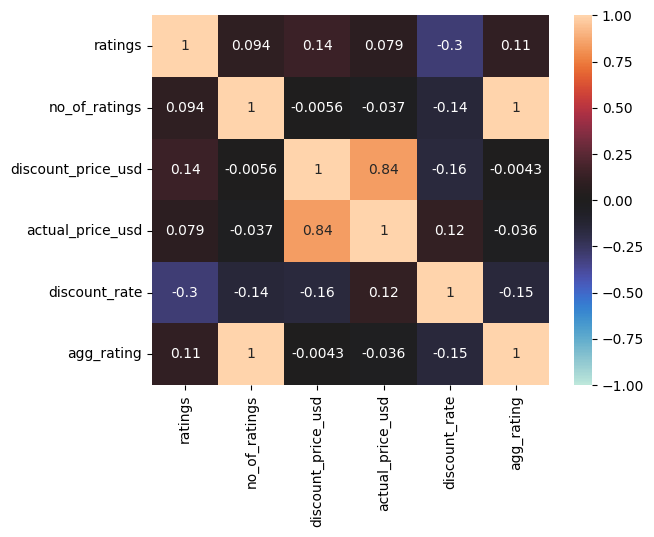

In [ ]:
sns.heatmap(amz_fashion_data.drop(amz_fashion_data.columns[0], axis=1).corr(), annot=True, vmin=-1, vmax=1, center=0)

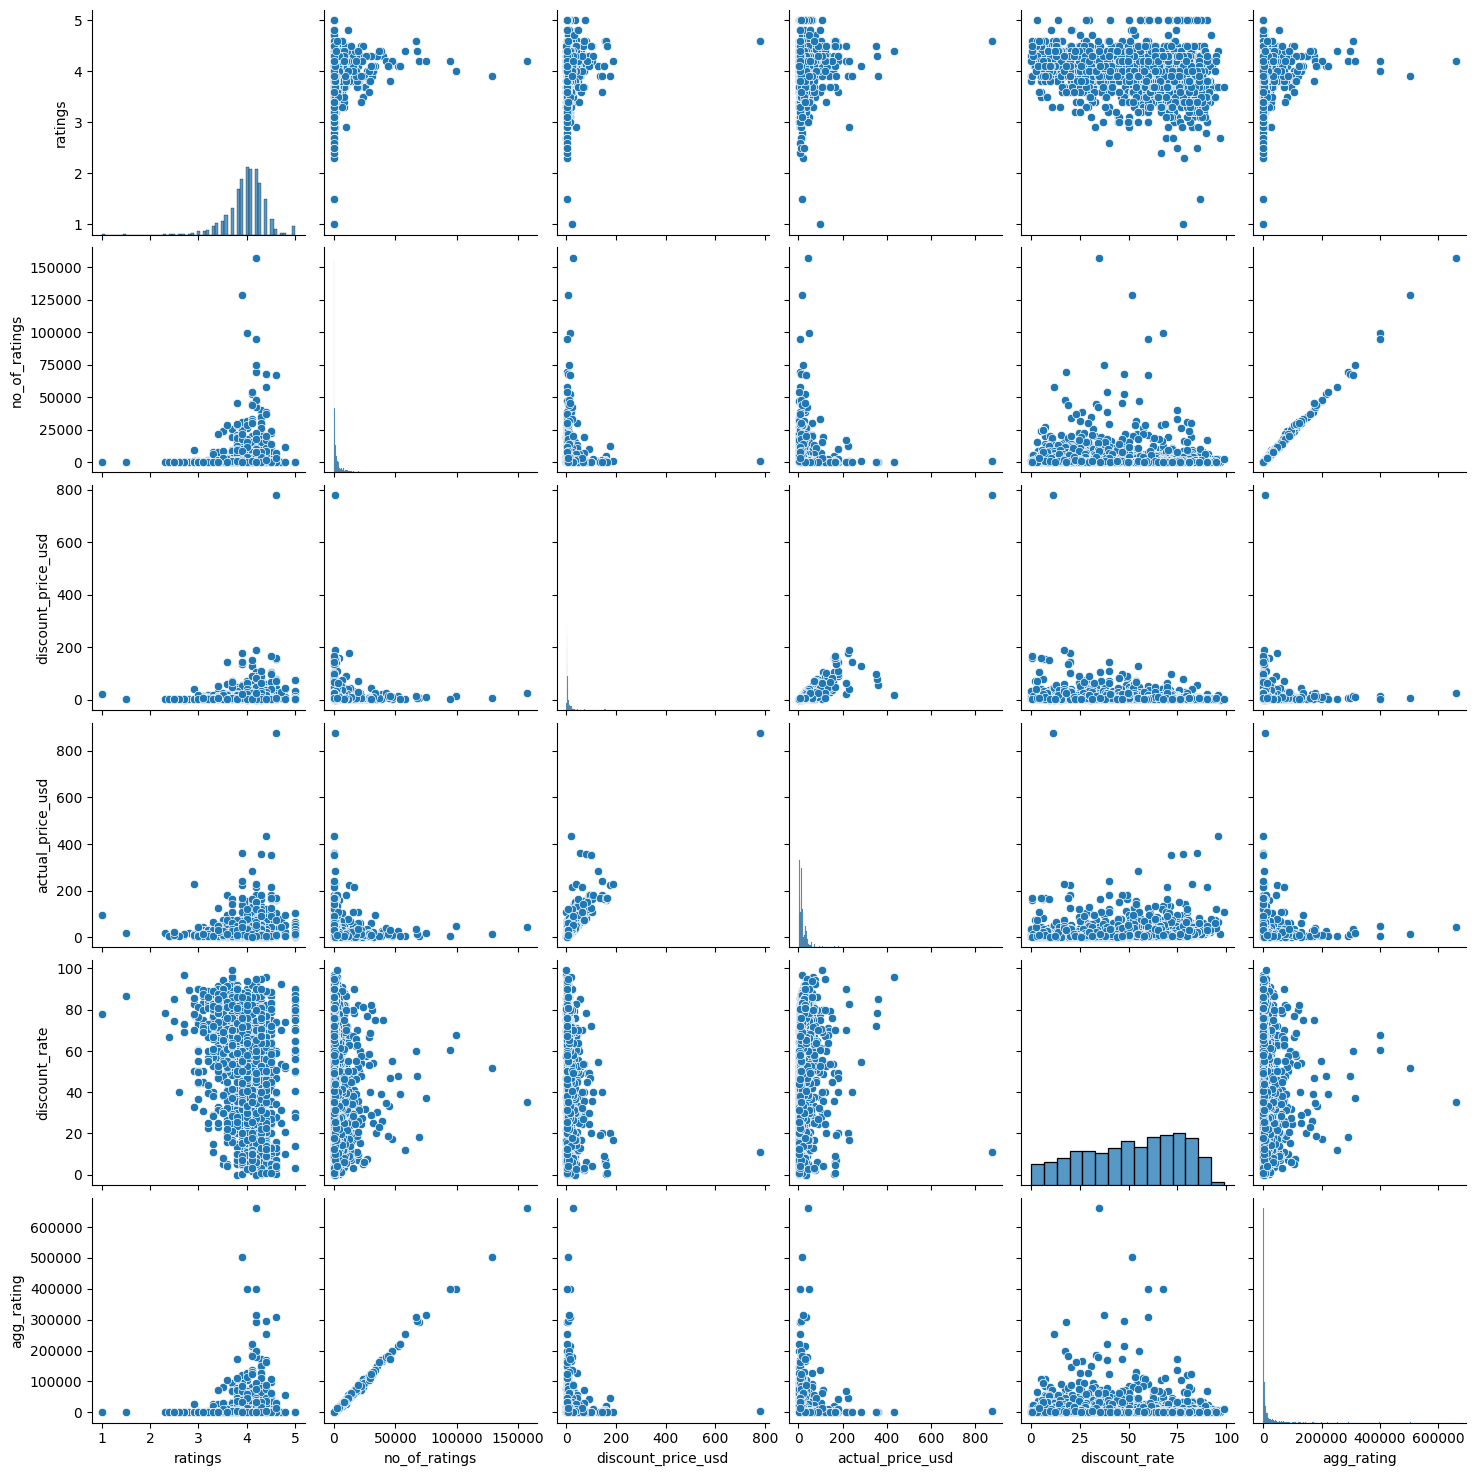

In [ ]:
sns.pairplot(amz_fashion_data)

# Television

## Number of observation
The raw data consists of __1104__ observations. After excluding null values and data with random strings in the price field and ratings, the pre-processed data consists of a total of __512__ observations.


In [ ]:
tv_raw_data = pd.read_csv("amazon_sales_prediction/dataset/Televisions.csv")
tv_raw_data.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,Samsung 80 cm (32 Inches) Wondertainment Serie...,"tv, audio & cameras",Televisions,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/Samsung-Inches-Wondertai...,4.2,"8,877","₹12,990","₹22,900"
1,MI 80 cm (32 inches) 5A Series HD Ready Smart ...,"tv, audio & cameras",Televisions,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/MI-inches-Ready-Android-...,4.2,"34,286","₹13,999","₹24,999"
2,Redmi 80 cm (32 inches) Android 11 Series HD R...,"tv, audio & cameras",Televisions,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/Redmi-inches-Ready-L32M6...,4.2,"47,642","₹13,999","₹24,999"
3,OnePlus 138 cm (55 inches) Y Series 4K Ultra H...,"tv, audio & cameras",Televisions,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/OnePlus-55-inches-Androi...,4.2,"8,290","₹38,999","₹49,999"
4,OnePlus 80 cm (32 inches) Y Series HD Ready LE...,"tv, audio & cameras",Televisions,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/OnePlus-inches-Ready-And...,4.2,"36,800","₹14,999","₹19,999"


In [ ]:
tv_raw_data.describe()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
count,1104,1104,1104,1104,1104,614,614,703,733
unique,1085,1,1,857,1104,29,193,413,356
top,GOQii Newly Launched Smart Vital MAX HD Displa...,"tv, audio & cameras",Televisions,https://m.media-amazon.com/images/I/41gmezKJxC...,https://www.amazon.in/Samsung-Inches-Wondertai...,4.2,1,"₹8,499","₹19,999"
freq,5,1104,1104,136,1,97,45,9,18


In [ ]:
tv_raw_data.shape

(1104, 9)

raw data has 1104 observation

In [ ]:
print(tv_raw_data.isnull().sum())

name                0
main_category       0
sub_category        0
image               0
link                0
ratings           490
no_of_ratings     490
discount_price    401
actual_price      371
dtype: int64


Drop instances that have null values for any of <b>name, rating, no_of_ratings, discount_price, actual_price</b>

In [ ]:
tv_raw_data.dropna(subset=['name', 'ratings', 'no_of_ratings', 'discount_price', 'actual_price'], inplace=True)
tv_raw_data.shape

(534, 9)

In [ ]:
print(tv_raw_data.isnull().sum())

name              0
main_category     0
sub_category      0
image             0
link              0
ratings           0
no_of_ratings     0
discount_price    0
actual_price      0
dtype: int64


We have now confirmed that there aren't any data will null <b>name, ratings, no_of_ratings, discount_price, actual_price</b>


We we now want to convert the currency. The dataset currently has the prices in Rupees, so we want to convert it to United States Dollars.

We also found out that some instances of <b>ratings</b> and <b>no_of_ratings</b> columns have strings that cannot be converted to a float. So we handle those cases here as well.

In [ ]:
exchange_rate = 1 / 82.99 # Exchange rate as of 02/08/2024

def rupee_to_usd(x):
  return float(x[1:].replace(",", "")) * exchange_rate
def str_to_float(x):
  return float(x.replace(",", ""))

tv_raw_data['discount_price_usd'] = tv_raw_data['discount_price'].apply(lambda x: rupee_to_usd(x))
tv_raw_data['actual_price_usd'] = tv_raw_data['actual_price'].apply(lambda x: rupee_to_usd(x))
tv_raw_data['ratings'] = tv_raw_data['ratings'].apply(lambda x: np.nan if not str(x).replace('.', '').isdigit() else float(x))
tv_raw_data['no_of_ratings'] = tv_raw_data['no_of_ratings'].apply(lambda x: np.nan if not str(x).replace(',', '').isdigit() else str_to_float(x))
tv_raw_data.dropna(subset=['no_of_ratings', 'ratings'], inplace=True)
tv_raw_data.shape


(512, 11)

After removing null and invalid values, 512 observations left

In [ ]:
tv_raw_data.describe().round(2)

,ratings,no_of_ratings,discount_price_usd,actual_price_usd
count,512.00,512.00,512.00,512.00
mean,4.05,2476.37,534.99,862.24
std,0.68,7311.87,914.45,1266.17
min,1.00,1.00,4.33,8.42
25%,3.90,13.00,138.56,275.94
50%,4.20,141.00,301.23,518.07
75%,4.40,1624.00,602.39,963.85
max,5.00,47642.00,15061.94,19217.98


We add new column, **discount_rate** and **agg_rating**

In [ ]:
tv_data = tv_raw_data[['sub_category', 'ratings', 'no_of_ratings', 'discount_price_usd', 'actual_price_usd']].copy()
tv_data['discount_rate'] = (tv_data['actual_price_usd'] - tv_data['discount_price_usd']) / tv_data['actual_price_usd'] * 100
tv_data['agg_rating'] = tv_data['ratings'] * tv_data['no_of_ratings']
tv_data.head()

,sub_category,ratings,no_of_ratings,discount_price_usd,actual_price_usd,discount_rate,agg_rating
0,Televisions,4.2,8877.0,156.524883,275.936860,43.275109,37283.4
1,Televisions,4.2,34286.0,168.682974,301.229064,44.001760,144001.2
2,Televisions,4.2,47642.0,168.682974,301.229064,44.001760,200096.4
3,Televisions,4.2,8290.0,469.924087,602.470177,22.000440,34818.0
4,Televisions,4.2,36800.0,180.732618,240.980841,25.001250,154560.0


<Axes: >

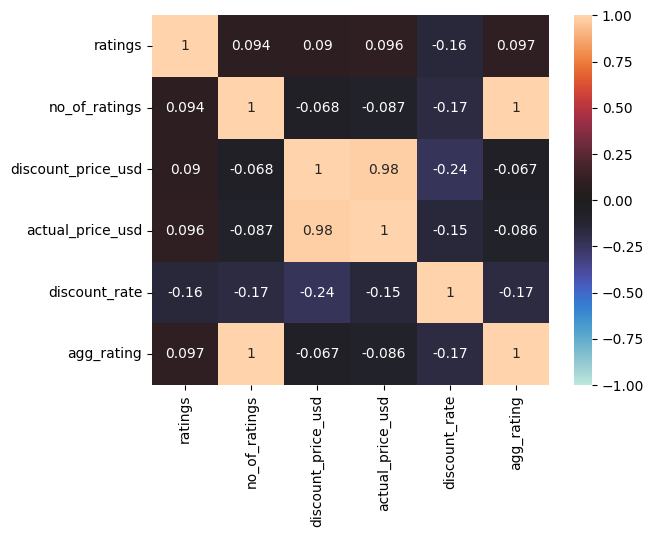

In [ ]:
sns.heatmap(tv_data.drop(tv_data.columns[0], axis=1).corr(), annot=True, vmin=-1, vmax=1, center=0)

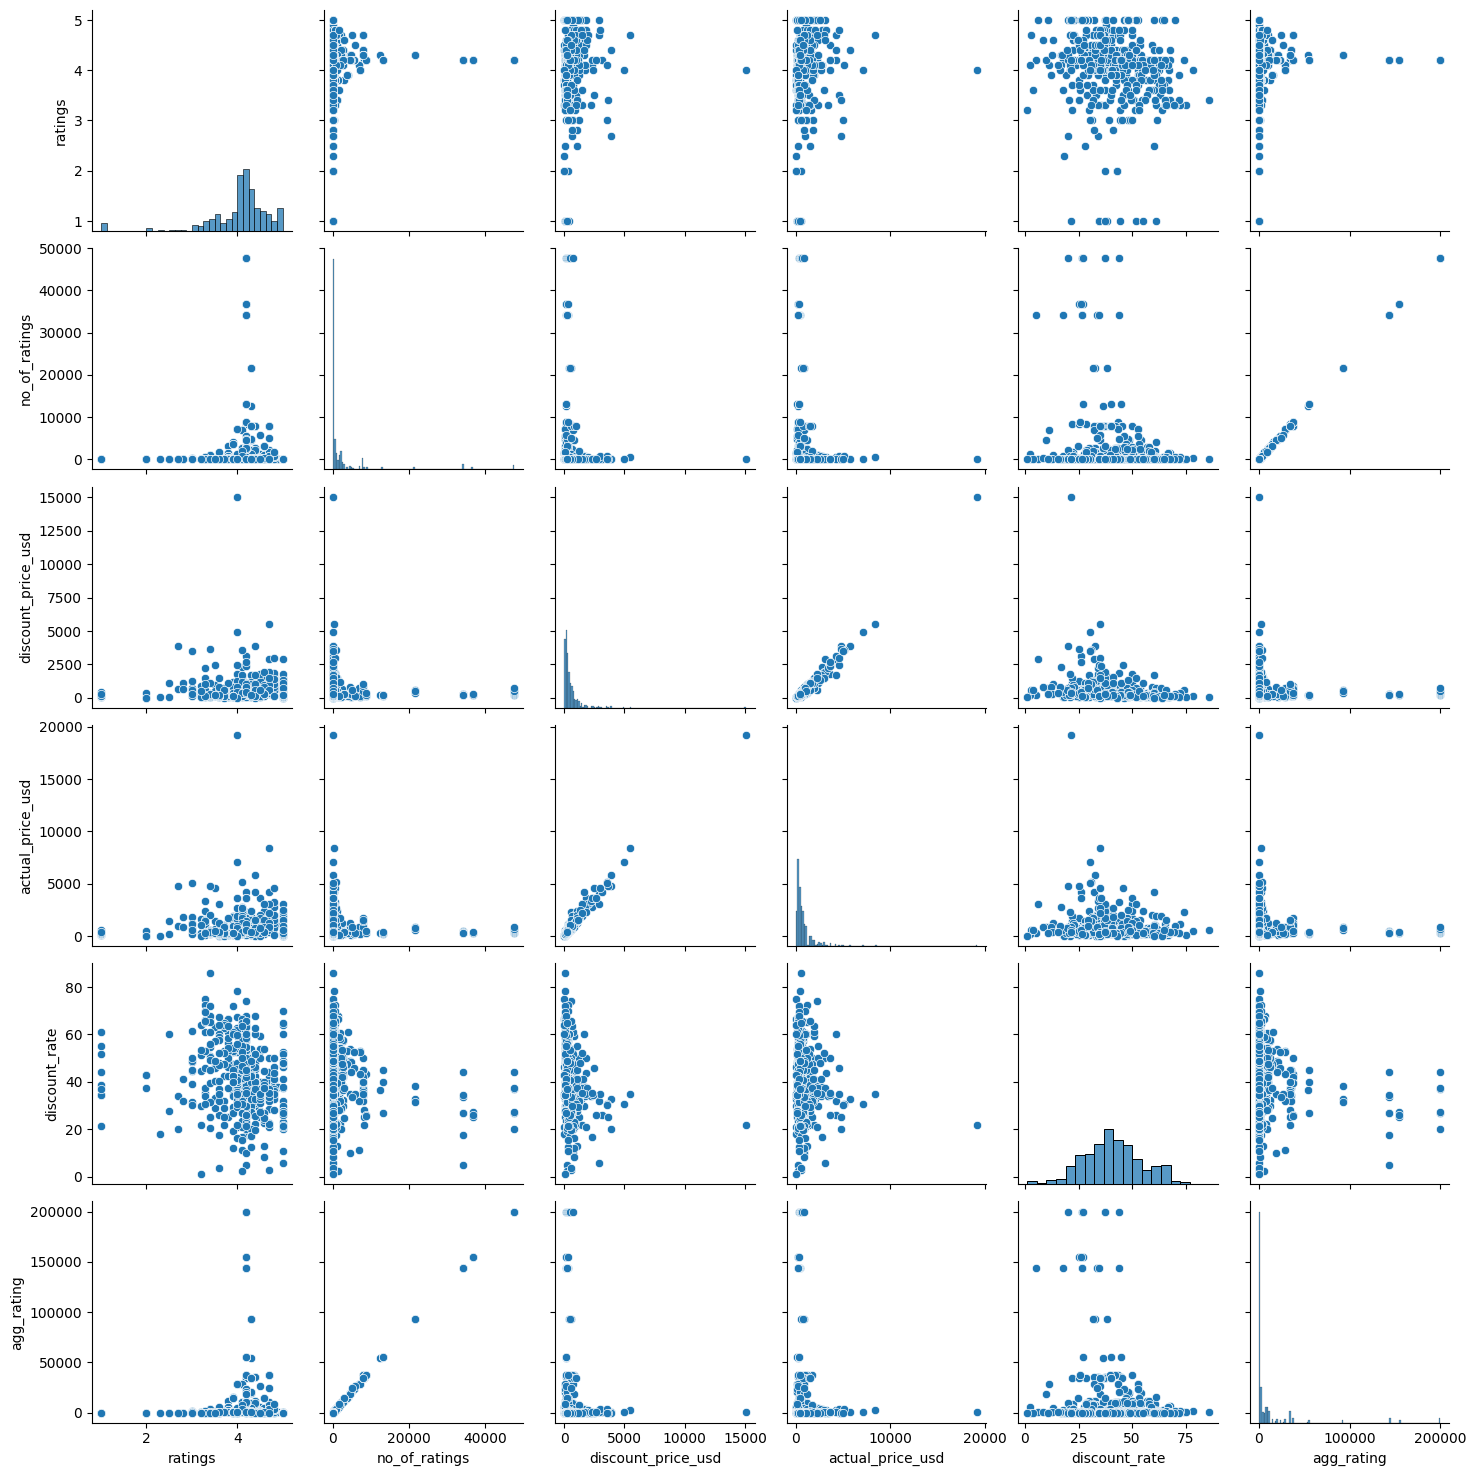

In [ ]:
sns.pairplot(tv_data)

# Luxury Beauty

## Number of observation
The raw data consists of __864__ observations. After excluding null values and data with random strings in the price field and ratings, the pre-processed data consists of a total of __281__ observations.


In [ ]:
luxury_raw_data = pd.read_csv("amazon_sales_prediction/dataset/Luxury Beauty.csv")
luxury_raw_data.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,O3+ Eye Circle Cream - Brightening & Whitening...,beauty & health,Luxury Beauty,https://m.media-amazon.com/images/I/31cr84-sGk...,https://www.amazon.in/O3-Eye-Circle-Cream-15g/...,3.8,"1,005",₹423,₹445
1,Biolage Hydrasource Conditioner | Paraben Free...,beauty & health,Luxury Beauty,https://m.media-amazon.com/images/I/71ZPyC85cD...,https://www.amazon.in/MATRIX-fbb-Biolage-Hydra...,4.2,342,NaN,₹180
2,"Tvaksh Faceguard Silicone Sunscreen Gel SPF30,...",beauty & health,Luxury Beauty,https://m.media-amazon.com/images/I/71fc+oPmz3...,https://www.amazon.in/Faceguard-Silicone-Sunsc...,4.3,149,₹441,₹501
3,Davidoff Cool Water For Men. Eau De Toilette S...,beauty & health,Luxury Beauty,https://m.media-amazon.com/images/I/410EqXHsCR...,https://www.amazon.in/Davidoff-Water-Toilette-...,4.2,"28,269","₹4,250","₹4,750"
4,De Fabulous Get Closer Scalp Aid Shampoo and C...,beauty & health,Luxury Beauty,https://m.media-amazon.com/images/I/51NQQCvk-f...,https://www.amazon.in/Fabulous-Closer-Shampoo-...,3.9,62,"₹2,565","₹2,700"


In [ ]:
luxury_raw_data.describe()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
count,864,864,864,864,864,587,587,537,847
unique,832,1,1,816,864,31,243,381,342
top,Essenza Di Wills Inizio Aqua Homme Luxury Eau ...,beauty & health,Luxury Beauty,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/O3-Eye-Circle-Cream-15g/...,Get,FREE Delivery by Amazon,"₹1,463",₹325
freq,2,864,864,4,1,67,58,9,29


In [ ]:
luxury_raw_data.shape

(864, 9)

raw data has 864 observation

In [ ]:
print(luxury_raw_data.isnull().sum())

name                0
main_category       0
sub_category        0
image               0
link                0
ratings           277
no_of_ratings     277
discount_price    327
actual_price       17
dtype: int64


Drop instances that have null values for any of <b>name, rating, no_of_ratings, discount_price, actual_price</b>

In [ ]:
luxury_raw_data.dropna(subset=['name', 'ratings', 'no_of_ratings', 'discount_price', 'actual_price'], inplace=True)
luxury_raw_data.shape

(335, 9)

In [ ]:
print(luxury_raw_data.isnull().sum())

name              0
main_category     0
sub_category      0
image             0
link              0
ratings           0
no_of_ratings     0
discount_price    0
actual_price      0
dtype: int64


We have now confirmed that there aren't any data will null <b>name, ratings, no_of_ratings, discount_price, actual_price</b>


We we now want to convert the currency. The dataset currently has the prices in Rupees, so we want to convert it to United States Dollars.

We also found out that some instances of <b>ratings</b> and <b>no_of_ratings</b> columns have strings that cannot be converted to a float. So we handle those cases here as well.

In [ ]:
exchange_rate = 1 / 82.99 # Exchange rate as of 02/08/2024

def rupee_to_usd(x):
  return float(x[1:].replace(",", "")) * exchange_rate
def str_to_float(x):
  return float(x.replace(",", ""))

luxury_raw_data['discount_price_usd'] = luxury_raw_data['discount_price'].apply(lambda x: rupee_to_usd(x))
luxury_raw_data['actual_price_usd'] = luxury_raw_data['actual_price'].apply(lambda x: rupee_to_usd(x))
luxury_raw_data['ratings'] = luxury_raw_data['ratings'].apply(lambda x: np.nan if not str(x).replace('.', '').isdigit() else float(x))
luxury_raw_data['no_of_ratings'] = luxury_raw_data['no_of_ratings'].apply(lambda x: np.nan if not str(x).replace(',', '').isdigit() else str_to_float(x))
luxury_raw_data.dropna(subset=['no_of_ratings', 'ratings'], inplace=True)
luxury_raw_data.shape


(281, 11)

After removing null and invalid values, 281 observations left

In [ ]:
luxury_raw_data.describe().round(2)

,ratings,no_of_ratings,discount_price_usd,actual_price_usd
count,281.00,281.00,281.00,281.00
mean,4.02,701.90,19.05,25.51
std,0.77,5363.35,22.35,29.15
min,1.00,1.00,0.41,0.59
25%,3.80,4.00,5.78,7.47
50%,4.20,33.00,9.69,12.65
75%,4.40,254.00,23.20,30.12
max,5.00,84763.00,156.28,180.73


We add new column, **discount_rate** and **agg_rating**

In [ ]:
luxury_data = luxury_raw_data[['sub_category', 'ratings', 'no_of_ratings', 'discount_price_usd', 'actual_price_usd']].copy()
luxury_data['discount_rate'] = (luxury_data['actual_price_usd'] - luxury_data['discount_price_usd']) / luxury_data['actual_price_usd'] * 100
luxury_data['agg_rating'] = luxury_data['ratings'] * luxury_data['no_of_ratings']
luxury_data.head()

,sub_category,ratings,no_of_ratings,discount_price_usd,actual_price_usd,discount_rate,agg_rating
0,Luxury Beauty,3.8,1005.0,5.097000,5.362092,4.943820,3819.0
2,Luxury Beauty,4.3,149.0,5.313893,6.036872,11.976048,640.7
3,Luxury Beauty,4.2,28269.0,51.210989,57.235812,10.526316,118729.8
4,Luxury Beauty,3.9,62.0,30.907338,32.534040,5.000000,241.8
5,Luxury Beauty,4.6,612.0,6.314014,7.169538,11.932773,2815.2


<Axes: >

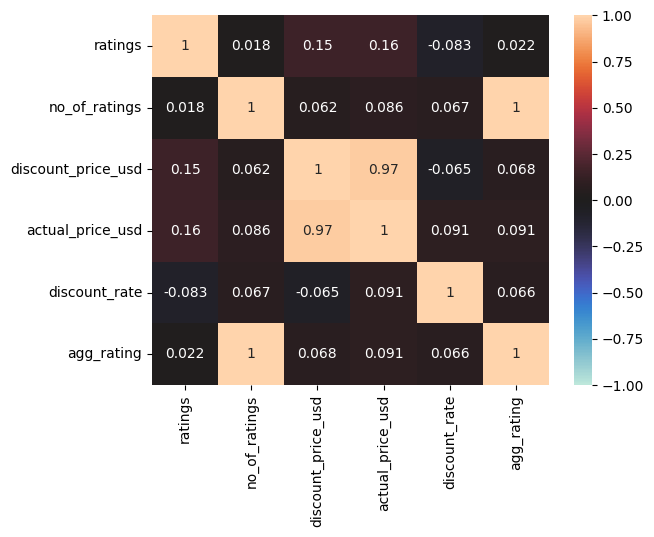

In [ ]:
sns.heatmap(luxury_data.drop(tv_data.columns[0], axis=1).corr(), annot=True, vmin=-1, vmax=1, center=0)

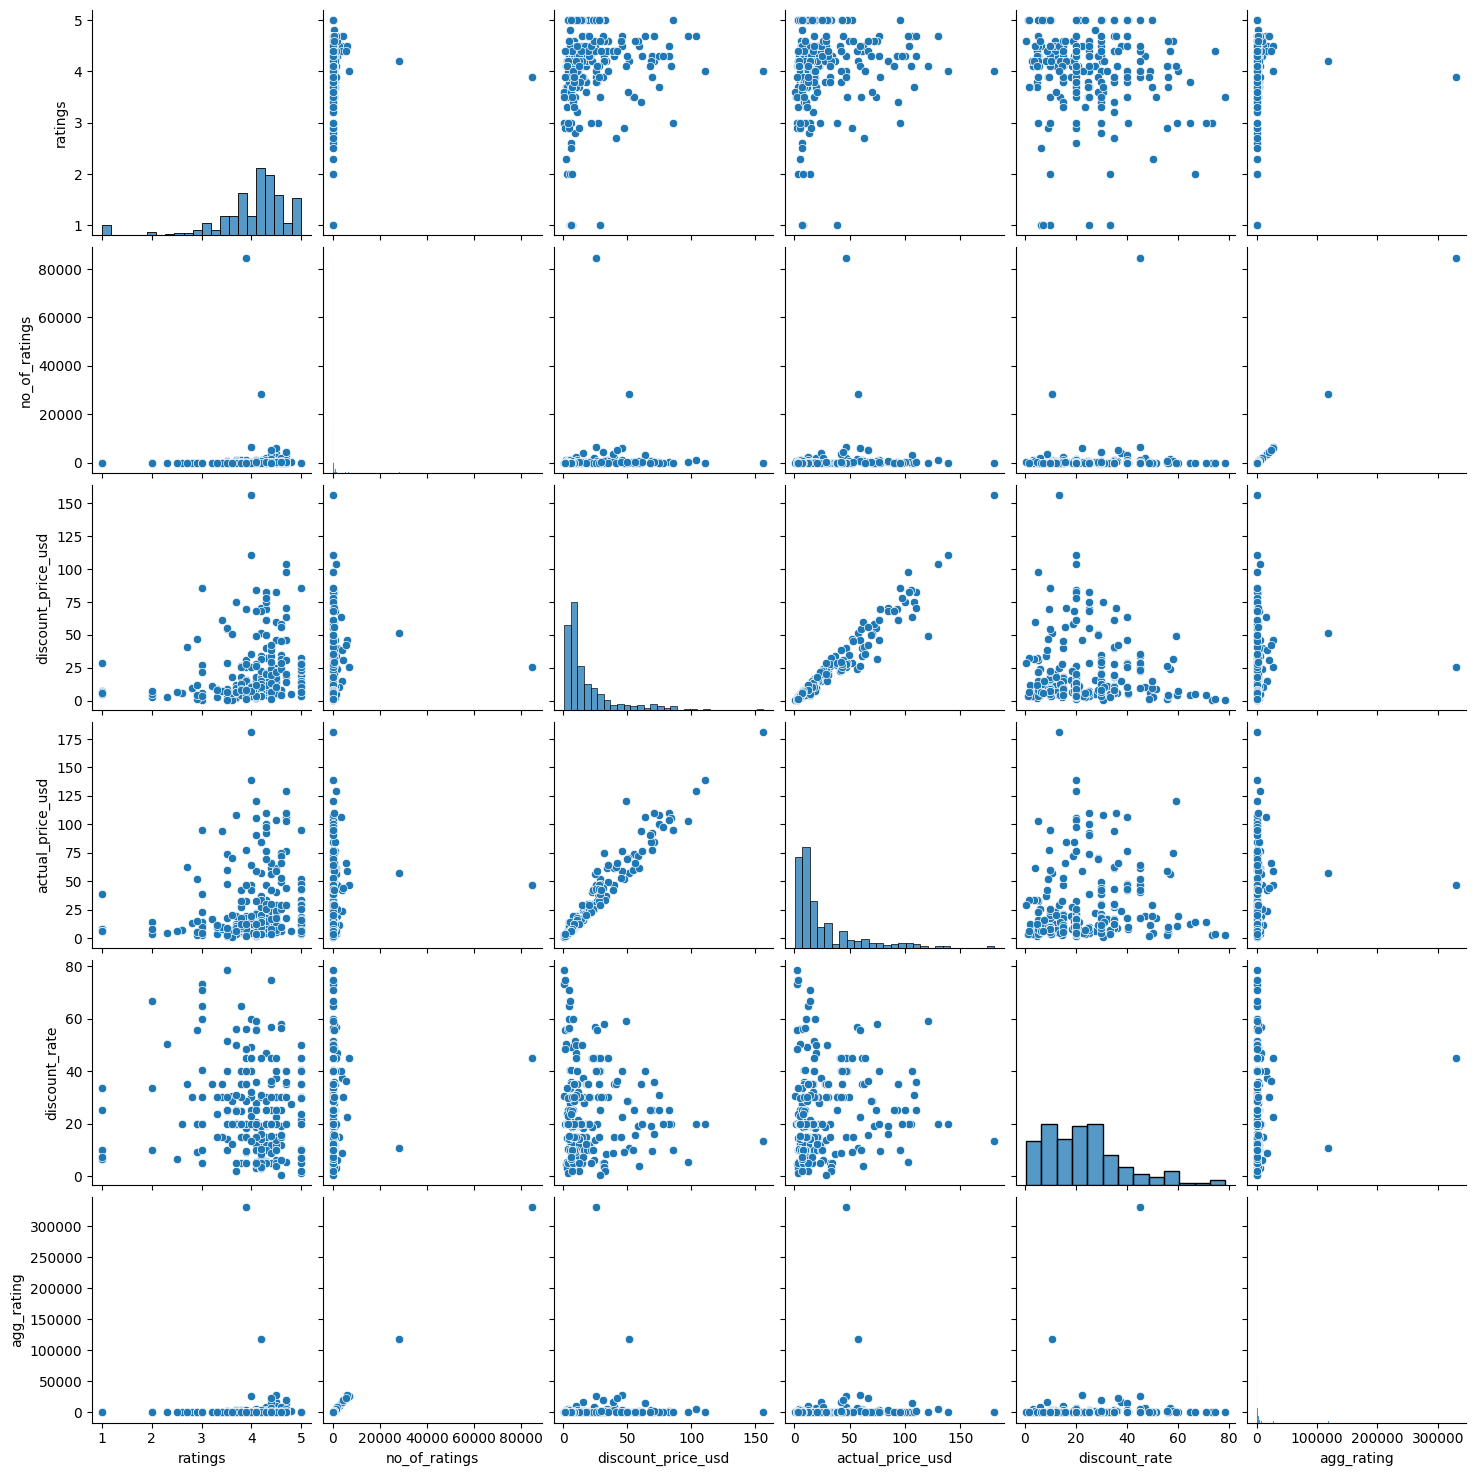

In [ ]:
sns.pairplot(luxury_data)

# Aggregating the 3 categories


In [ ]:
combined_data = pd.concat([amz_fashion_data, tv_data, luxury_data], ignore_index=True)
combined_data.shape

(2778, 7)

In [ ]:
combined_data.head()

,sub_category,ratings,no_of_ratings,discount_price_usd,actual_price_usd,discount_rate,agg_rating
0,Amazon Fashion,4.2,3628.0,4.229425,4.807808,12.030075,15237.6
1,Amazon Fashion,3.9,291.0,3.000361,12.037595,75.075075,1134.9
2,Amazon Fashion,4.4,2950.0,1.506206,1.927943,21.875000,12980.0
3,Amazon Fashion,4.0,17985.0,3.602844,9.627666,62.578223,71940.0
4,Amazon Fashion,4.3,5830.0,5.398241,6.012773,10.220441,25069.0


Shuffle the dataset so that it's shuffled within sub_categories

In [ ]:
data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,sub_category,ratings,no_of_ratings,discount_price_usd,actual_price_usd,discount_rate,agg_rating
0,Amazon Fashion,4.1,2092.0,4.590915,7.205687,36.287625,8577.2
1,Televisions,4.4,7943.0,132.534040,240.872394,44.977489,34949.2
2,Amazon Fashion,3.8,229.0,2.482227,12.049645,79.400000,870.2
3,Amazon Fashion,3.7,33.0,2.156886,18.062417,88.058706,122.1
4,Luxury Beauty,3.6,37.0,0.409688,0.590433,30.612245,133.2


Convert the sub_category into integer values for categories.

The mapping is as follows:


*   Amazon Fashion: 0
*   Televisions: 1
*   Luxury Beauty: 2



In [ ]:
sub_category_mapping = {'Amazon Fashion': 0, 'Televisions': 1, 'Luxury Beauty': 2}

data['sub_category'] = data['sub_category'].map(sub_category_mapping)
data.head()

,sub_category,ratings,no_of_ratings,discount_price_usd,actual_price_usd,discount_rate,agg_rating
0,0,4.1,2092.0,4.590915,7.205687,36.287625,8577.2
1,1,4.4,7943.0,132.534040,240.872394,44.977489,34949.2
2,0,3.8,229.0,2.482227,12.049645,79.400000,870.2
3,0,3.7,33.0,2.156886,18.062417,88.058706,122.1
4,2,3.6,37.0,0.409688,0.590433,30.612245,133.2


Make sure that all the sub_category values have been converted to 0, 1, or 2

In [ ]:
print(data['sub_category'].value_counts())

0    1985
1     512
2     281
Name: sub_category, dtype: int64


## Data Visualization

<Axes: >

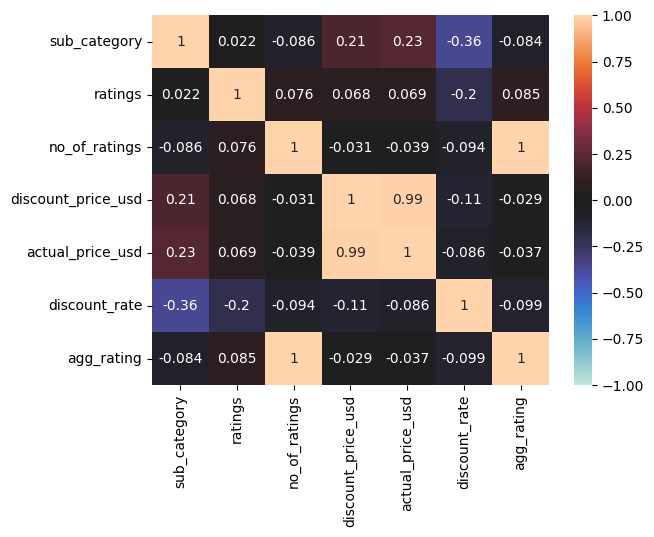

In [ ]:
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, center=0)

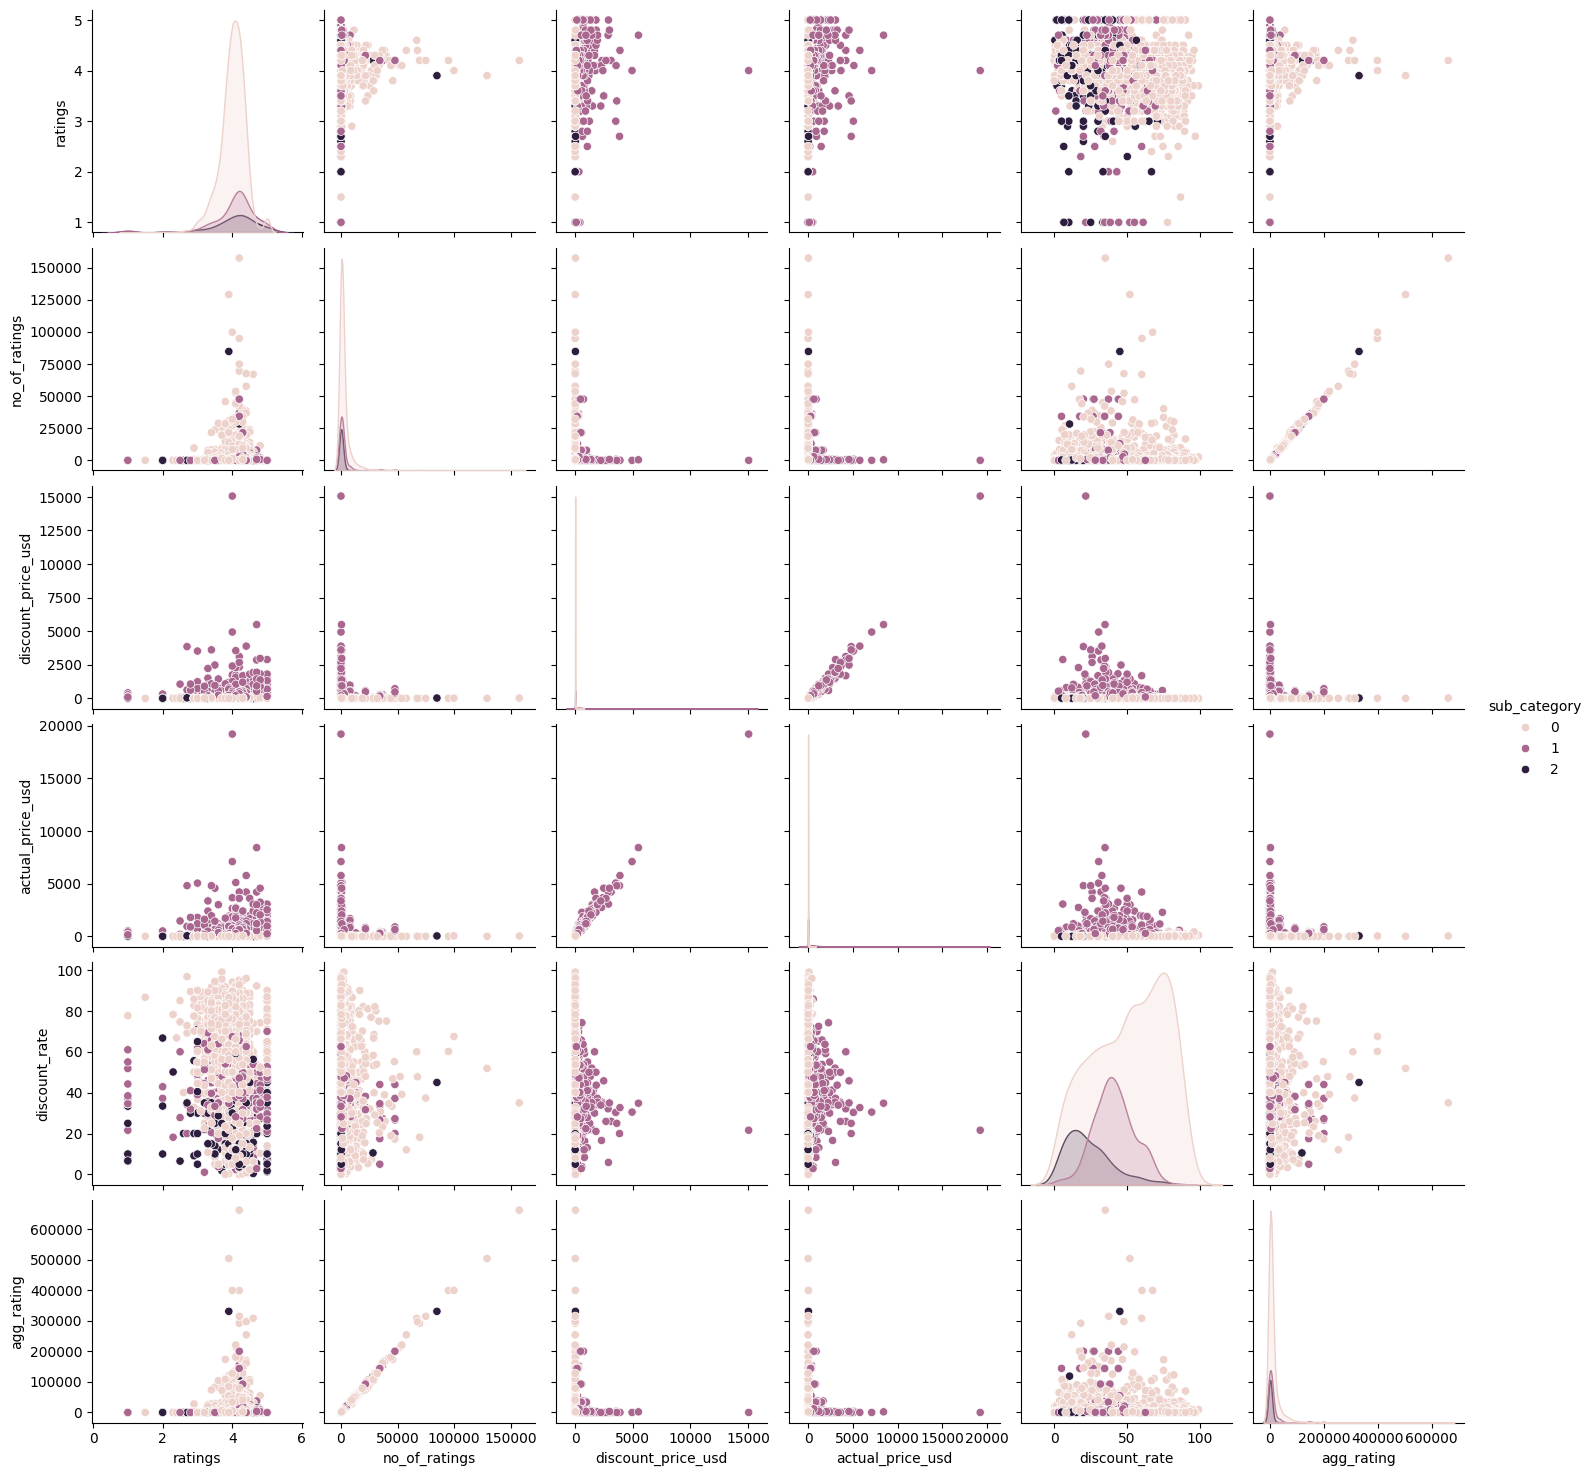

In [ ]:
sns.pairplot(data, hue="sub_category")

## Normalization

Now let's normalize **data** using min-max normalization



In [ ]:
from sklearn.preprocessing import MinMaxScaler
sub_cat = data['sub_category']
data_for_normalize = data.drop(columns=['sub_category'])

scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(data_for_normalize), columns=data_for_normalize.columns)

normalized_data['sub_category'] = sub_cat
normalized_data.describe().round(2)

,ratings,no_of_ratings,discount_price_usd,actual_price_usd,discount_rate,agg_rating,sub_category
count,2778.00,2778.00,2778.00,2778.00,2778.00,2778.00,2778.00
mean,0.75,0.02,0.01,0.01,0.47,0.02,0.39
std,0.12,0.05,0.03,0.03,0.24,0.05,0.66
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.70,0.00,0.00,0.00,0.28,0.00,0.00
50%,0.77,0.00,0.00,0.00,0.47,0.00,0.00
75%,0.82,0.01,0.00,0.00,0.67,0.01,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,2.00


# Our first model: Polynomial Regression

Our goal is to find the best discount rate, given an existing product with some number of ratings. Our heuristic for the best discount rate is the highest rating. Thus, we will develop our model to predict the ratings given the other columns in the normalized data

In [ ]:
from sklearn.model_selection import train_test_split

y = normalized_data['ratings']
X = normalized_data.drop('ratings', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X

(2500, 6)
(278, 6)
(2500,)
(278,)


,no_of_ratings,discount_price_usd,actual_price_usd,discount_rate,agg_rating,sub_category
0,0.013278,0.000281,0.000354,0.366595,0.012966,0
1,0.050432,0.008775,0.012513,0.454388,0.052839,1
2,0.001448,0.000141,0.000606,0.802158,0.001314,0
3,0.000203,0.000119,0.000919,0.889636,0.000183,0
4,0.000229,0.000003,0.000010,0.309257,0.000200,2
...,...,...,...,...,...,...
2773,0.000711,0.000335,0.000606,0.556202,0.000545,0
2774,0.000368,0.000452,0.000603,0.406132,0.000373,0
2775,0.008579,0.000173,0.000167,0.179065,0.008175,0
2776,0.000210,0.000535,0.000982,0.568629,0.000199,0


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_mse_arr = []
train_mse_arr = []
best_model = None
best_mse = float('inf')

for degree in degrees:
  polynomial = PolynomialFeatures(degree=degree)
  X_train_poly = polynomial.fit_transform(X_train)
  X_test_poly = polynomial.fit_transform(X_test)

  model = LinearRegression()
  model.fit(X_train_poly, y_train)

  Y_pred = model.predict(X_test_poly)
  Y_train_pred = model.predict(X_train_poly)

  test_mse = mean_squared_error(y_test, Y_pred)
  train_mse = mean_squared_error(y_train, Y_train_pred)
  test_mse_arr.append(test_mse)
  train_mse_arr.append(train_mse)
  print(f'Degree = {degree}: Testing MSE = {test_mse}, Training MSE = {train_mse}')

  if test_mse < best_mse:
    best_model = model
    best_mse = min(test_mse, best_mse)

Degree = 1: Testing MSE = 0.02029888491518177, Training MSE = 0.013405055282654585
Degree = 2: Testing MSE = 0.020090995204817108, Training MSE = 0.012758317342551803
Degree = 3: Testing MSE = 0.019547535944113525, Training MSE = 0.0117217271095025
Degree = 4: Testing MSE = 0.15726472723310386, Training MSE = 0.010945309278314365
Degree = 5: Testing MSE = 16.60923722340633, Training MSE = 0.009978378683230173
Degree = 6: Testing MSE = 1549.3404387248033, Training MSE = 0.008545890743471275
Degree = 7: Testing MSE = 3440204.9137145407, Training MSE = 0.007715515735917609
Degree = 8: Testing MSE = 4374141.090258828, Training MSE = 0.007413590526797809
Degree = 9: Testing MSE = 12561992.852548325, Training MSE = 0.006621683831947473
Degree = 10: Testing MSE = 5382891.441292655, Training MSE = 0.006399410015419427


## Fitting Graphs

Based on the test mean squared loss, we can deduce that the polynomial regression with degree=3 provides us with a reliable model. Models with higher degrees tend to over fit.

Below is a graphical visualization of the train and test MSE over degree. I have omitted the degrees 5 and above because the y-axis scale becomes too big.

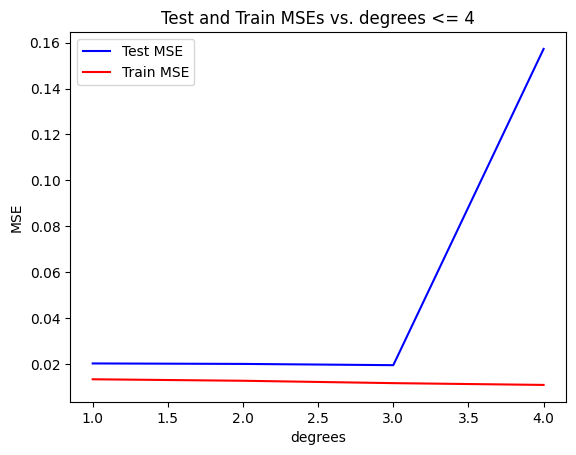

In [ ]:
plt.plot(degrees[:4], test_mse_arr[:4], label='Test MSE', color='blue')
plt.plot(degrees[:4], train_mse_arr[:4], label='Train MSE', color='red')
plt.xlabel('degrees')
plt.ylabel('MSE')
plt.title('Test and Train MSEs vs. degrees <= 4')
plt.legend()
plt.show()

On a log scale, we can see that testing loss at degree=2 shifts downwards from degree=1

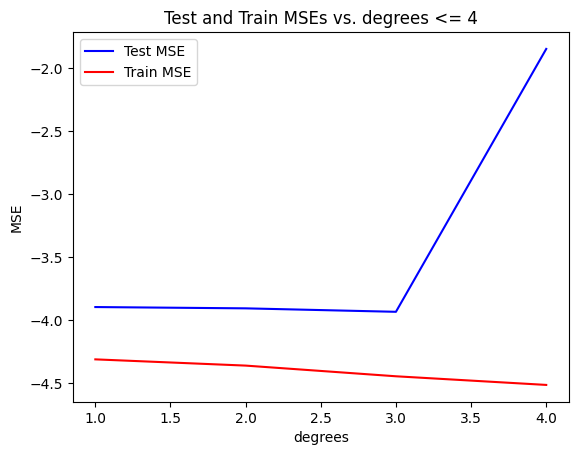

In [ ]:
plt.plot(degrees[:4], np.log(test_mse_arr[:4]), label='Test MSE', color='blue')
plt.plot(degrees[:4], np.log(train_mse_arr[:4]), label='Train MSE', color='red')
plt.xlabel('degrees')
plt.ylabel('MSE')
plt.title('Test and Train MSEs vs. degrees <= 4')
plt.legend()
plt.show()

More specifically, let's look at degrees <= 3

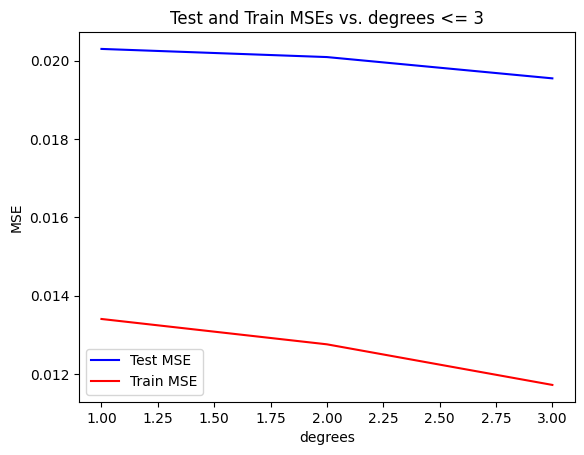

In [ ]:
plt.plot(degrees[:3], test_mse_arr[:3], label='Test MSE', color='blue')
plt.plot(degrees[:3], train_mse_arr[:3], label='Train MSE', color='red')
plt.xlabel('degrees')
plt.ylabel('MSE')
plt.title('Test and Train MSEs vs. degrees <= 3')
plt.legend()
plt.show()

As shown above, the model is the lowest testing MSE at degree is 2. So in terms of the fitting graph, the model is at the ideal range for model complexity.

## Testing out our model with a forward pass

In [ ]:
sample1 = normalized_data.iloc[0]

polynomial = PolynomialFeatures(degree=2)
X_train_poly = polynomial.fit_transform(X_train)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y1 = sample1['ratings']
x1 = sample1.drop('ratings')
x1 = x1.to_frame().T
x1_poly = polynomial.fit_transform(x1)

yhat1 = model.predict(x1_poly)
print(f'Expected: {y1}, Prediction: {yhat1}')

Expected: 0.7749999999999999, Prediction: [0.7683032]


In [ ]:
sample2 = normalized_data.iloc[1]

y2 = sample2['ratings']
x2 = sample2.drop('ratings')
x2 = x2.to_frame().T
x2_poly = polynomial.fit_transform(x2)

yhat2 = model.predict(x2_poly)
print(f'Expected: {y2}, Prediction: {yhat2}')


Expected: 0.8500000000000001, Prediction: [0.83424945]


In [ ]:
sample3 = normalized_data.iloc[1000]

y3 = sample3['ratings']
x3 = sample3.drop('ratings')
x3 = x3.to_frame().T
x3_poly = polynomial.fit_transform(x3)

yhat3 = model.predict(x3_poly)
print(f'Expected: {y3}, Prediction: {yhat3}')


Expected: 0.875, Prediction: [0.7563737]


In [ ]:
sample4 = normalized_data.iloc[2000]

y4 = sample4['ratings']
x4 = sample4.drop('ratings')
x4 = x4.to_frame().T
x4_poly = polynomial.fit_transform(x4)

yhat4 = model.predict(x4_poly)
print(f'Expected: {y4}, Prediction: {yhat4}')

Expected: 0.75, Prediction: [0.76109854]


In [ ]:
sample5 = normalized_data.iloc[2200]

y5 = sample5['ratings']
x5 = sample5.drop('ratings')
x5 = x5.to_frame().T
x5_poly = polynomial.fit_transform(x5)

yhat5 = model.predict(x5_poly)
print(f'Expected: {y5}, Prediction: {yhat5}')

Expected: 0.875, Prediction: [0.75384094]


As shown above, although the testing loss is low, some of the forward pass through the degree=2 polynomial regression results in a pretty big difference between expected and predicted ratings values.

5. What are the next 2 models you are thinking of and why?

Based on the observation that the correlation matrix did not reveal significant linear relationships, we chose polynomial regression. Even though polynomial regression yielded satisfactory results, it is likely due to the clustering of ratings between 3 and 4. the next two models we are considering are:

Neural Network:
A neural network would be a good choice for modeling the relationship between rating and the features such as no_of_ratings, discount_price_usd, actual_price_usd, discount_rate, and agg_rating, as there may be complex nonlinear relationships. This is because neural networks is good at capturing complex nonlinear patterns, and they offer the flexibility to fine-tune hyperparameters, including various loss functions and activation functions, to adapt to the characteristics of the dataset.

SVM:
SVM can also handle nonlinear relationships between ratings and the product information. By categorizing ratings into discrete classes (e.g., 1, 2, 3, 4, 5), we can expect that SVM can effectively classify ratings based on the given features of the product.

7. Conclusion section: What is the conclusion of your 1st model? What can be done to possibly improve it?

The optimal complexity (degree) of the polynomial regression model was determined to be degree 3. While the model's performance(MSE) was good, it may have been influenced by the clustering of ratings around 3 and 4. To address this issue and potentially improve the polynomial model, we can consider
the following:

Oversampling the classes with fewer ratings: replicating samples from classes with fewer ratings can help balance the dataset.

Cross-validation (e.g., k-fold): Validate the performance of the polynomial model using techniques like k-fold cross-validation to ensure that degree 3 is indeed the optimal choice. This can provide additional confidence in the chosen complexity of the model and help assess its generalization ability.

